# Data Preparation

In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
behrad3d_nasa_cmaps_path = kagglehub.dataset_download('behrad3d/nasa-cmaps')

print('Data source import complete.')


Using Colab cache for faster access to the 'nasa-cmaps' dataset.
Data source import complete.


### Load Dataset and Define Columns

In [2]:
import os
import pandas as pd

# print to confirm
print(behrad3d_nasa_cmaps_path)

# Path to CMaps folder
cmaps_path = os.path.join(behrad3d_nasa_cmaps_path, "CMaps")

# Define columns
columns = [
    "engine_id", "time_in_cycles",
    "op_setting_1", "op_setting_2", "op_setting_3"
] + [f"sensor_{i}" for i in range(1, 22)]

# Load datasets

train_df = pd.read_csv(os.path.join(cmaps_path, "train_FD001.txt"),
                       sep=r"\s+", header=None, names=columns, index_col=False)
test_df = pd.read_csv(os.path.join(cmaps_path, "test_FD001.txt"),
                      sep=r"\s+", header=None, names=columns, index_col=False)
rul_df = pd.read_csv(os.path.join(cmaps_path, "RUL_FD001.txt"),
                     header=None, names=["RUL"])


/kaggle/input/nasa-cmaps


###Drop columns with constant values as they provide no predictive power


In [3]:
constant_cols = [col for col in train_df.columns if train_df[col].nunique() == 1]

print("Columns with constant values:", constant_cols)
train_df.drop(constant_cols, axis=1, inplace=True, errors='ignore')
test_df.drop(constant_cols, axis=1, inplace=True, errors='ignore')

Columns with constant values: ['op_setting_3', 'sensor_1', 'sensor_5', 'sensor_10', 'sensor_16', 'sensor_18', 'sensor_19']


### Calculate RUL for the training data


In [4]:
# Calculate the maximum cycle for each engine
max_cycles_df = train_df.groupby('engine_id')['time_in_cycles'].max().reset_index()
max_cycles_df.columns = ['engine_id', 'max_cycles']

# Merge the max cycle info back into the training dataframe
train_df = pd.merge(train_df, max_cycles_df, on='engine_id', how='left')

# Calculate RUL
train_df['RUL'] = train_df['max_cycles'] - train_df['time_in_cycles']

# Drop helper column
train_df.drop(columns=['max_cycles'], inplace=True)

# Cap RUL at 125
train_df['RUL'] = train_df['RUL'].clip(upper=125)

print("RUL column calculated, capped at 125, and added to the training data.")
train_df.head()


RUL column calculated, capped at 125, and added to the training data.


,engine_id,time_in_cycles,op_setting_1,op_setting_2,sensor_2,sensor_3,sensor_4,sensor_6,sensor_7,sensor_8,sensor_9,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_17,sensor_20,sensor_21,RUL
0,1,1,-0.0007,-0.0004,641.82,1589.70,1400.60,21.61,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,125
1,1,2,0.0019,-0.0003,642.15,1591.82,1403.14,21.61,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,125
2,1,3,-0.0043,0.0003,642.35,1587.99,1404.20,21.61,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,125
3,1,4,0.0007,0.0000,642.35,1582.79,1401.87,21.61,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,125
4,1,5,-0.0019,-0.0002,642.37,1582.85,1406.22,21.61,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,125


# EDA + Feature Building

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler


### Set a seed for reproducibility


In [6]:
# Define a seed value for reproducibility
SEED_VALUE = 42

# 1. Set the `PYTHONHASHSEED` environment variable
import os
os.environ['PYTHONHASHSEED'] = str(SEED_VALUE)

# 2. Set the `python` built-in random seed
import random
random.seed(SEED_VALUE)

# 3. Set the `numpy` random seed
import numpy as np
np.random.seed(SEED_VALUE)

# 4. Set the `tensorflow` random seed
import tensorflow as tf
tf.random.set_seed(SEED_VALUE)

print("Random seeds are set for reproducibility.")

Random seeds are set for reproducibility.


In [7]:
def generate_sequences(df, sequence_length, feature_cols):
    """
    Generates sequences of data and corresponding targets for the LSTM model.
    The target is the RUL at the end of each sequence.
    """
    sequences, targets = [], []

    # Generate sequences for each unique engine_id
    for engine_id in df['engine_id'].unique():
        engine_df = df[df['engine_id'] == engine_id]

        # Create sequences of length sequence_length
        # The loop iterates up to the point where a full sequence can be formed
        for i in range(len(engine_df) - sequence_length + 1):
            seq = engine_df[feature_cols].iloc[i:i+sequence_length].values
            target = engine_df['RUL'].iloc[i+sequence_length-1]
            sequences.append(seq)
            targets.append(target)

    return np.array(sequences), np.array(targets)

# Identify feature columns
feature_cols = train_df.columns.drop(['engine_id', 'time_in_cycles', 'RUL'])

# Scale features using MinMaxScaler
scaler = MinMaxScaler()
train_df[feature_cols] = scaler.fit_transform(train_df[feature_cols])
test_df[feature_cols] = scaler.transform(test_df[feature_cols])

# Generate sequences
sequence_length = 50
X_train_lstm, y_train_lstm = generate_sequences(train_df, sequence_length, feature_cols)

### Prepare the test data, taking only the last sequence for each engine


In [8]:
# We need to find the last sequence for each engine in the test set
X_test_lstm = []

for engine_id in test_df['engine_id'].unique():
    engine_df = test_df[test_df['engine_id'] == engine_id]

    # Get the last 'sequence_length' measurements
    last_sequence = engine_df[feature_cols].tail(sequence_length).values

    # If an engine has fewer cycles than sequence_length, we pad with zeros at the beginning
    if len(last_sequence) < sequence_length:
        padded_sequence = np.zeros((sequence_length, len(feature_cols)))
        padded_sequence[-len(last_sequence):] = last_sequence
        X_test_lstm.append(padded_sequence)
    else:
        X_test_lstm.append(last_sequence)

X_test_lstm = np.array(X_test_lstm)

# The ground truth RUL values correspond to these test sequences
y_test_lstm = rul_df['RUL'].values

print(f"LSTM Test features shape: {X_test_lstm.shape}")
print(f"LSTM Test targets shape: {y_test_lstm.shape}")

LSTM Test features shape: (100, 50, 17)
LSTM Test targets shape: (100,)


### Some useful plots to get more grasp of the data.


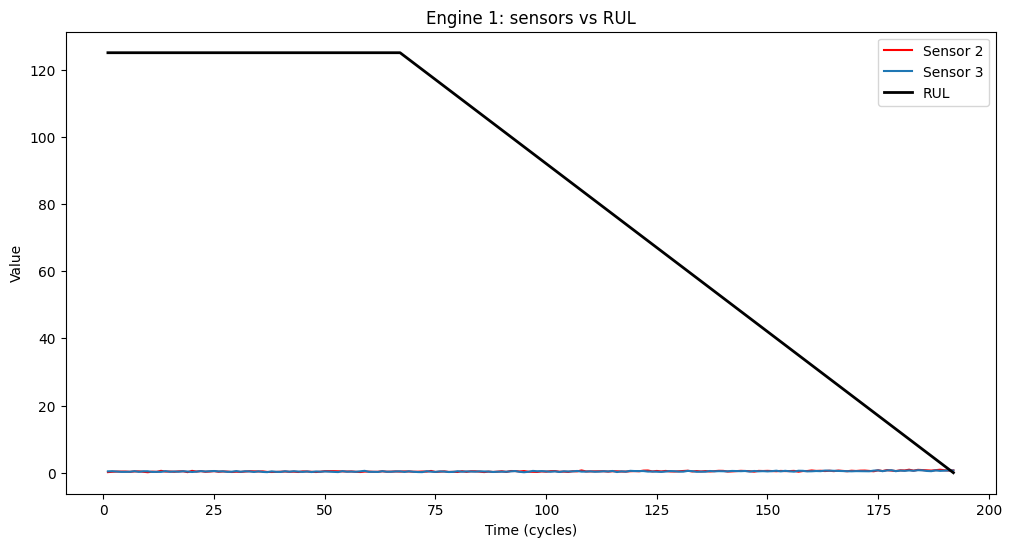

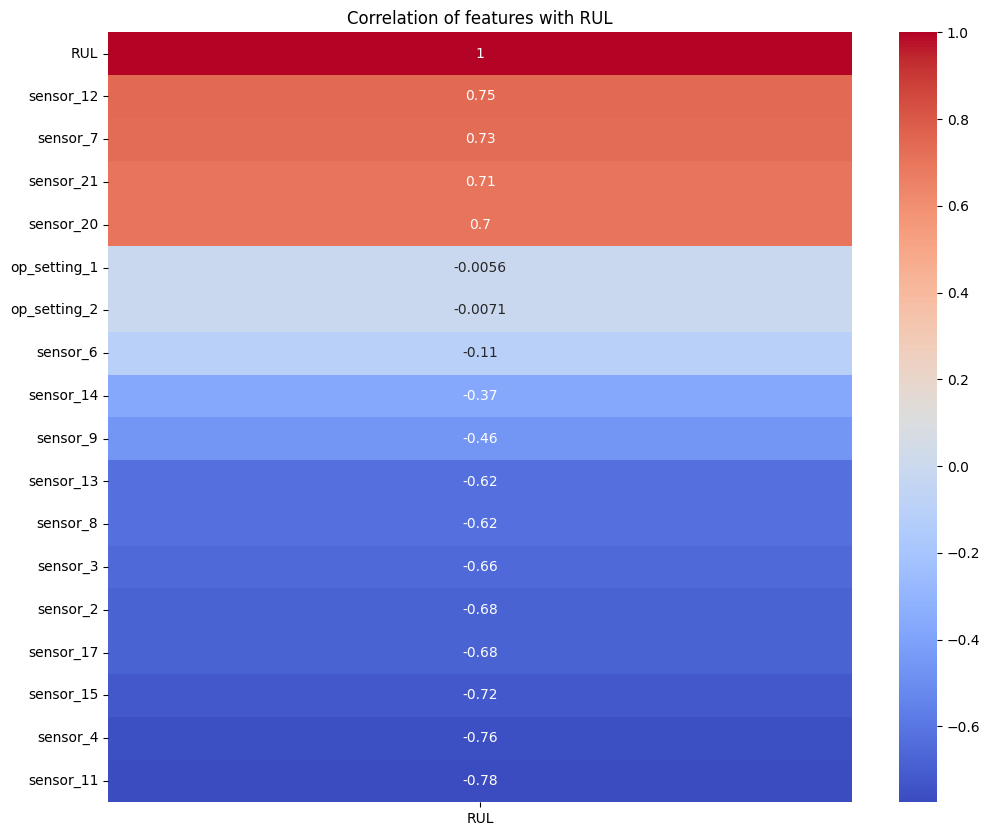

In [9]:
import matplotlib.pyplot as plt

engine_id = 1
df_plot = train_df[train_df['engine_id'] == engine_id]

plt.figure(figsize=(12,6))
plt.plot(df_plot['time_in_cycles'], df_plot['sensor_2'], label='Sensor 2', color='Red')
plt.plot(df_plot['time_in_cycles'], df_plot['sensor_3'], label='Sensor 3')
plt.plot(df_plot['time_in_cycles'], df_plot['RUL'], label='RUL', color='black', linewidth=2)

plt.xlabel('Time (cycles)')
plt.ylabel('Value')
plt.title(f'Engine {engine_id}: sensors vs RUL')
plt.legend()
plt.show()

import seaborn as sns

corr = train_df[feature_cols.tolist() + ['RUL']].corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr[['RUL']].sort_values('RUL', ascending=False),
            annot=True, cmap='coolwarm')
plt.title('Correlation of features with RUL')
plt.show()


# Model Training & Validation

In [10]:
from tensorflow.keras.callbacks import EarlyStopping

# Determine the input shape from our training data (sequence_length, num_features)
input_shape = (X_train_lstm.shape[1], X_train_lstm.shape[2])

# Build the LSTM model
lstm_model = Sequential()

# Add the explicit Input layer
# lstm_model.add(Input(shape=input_shape))
lstm_model.add(LSTM(128, return_sequences=True, input_shape=input_shape))
lstm_model.add(Dropout(0.3))

# First LSTM layer with Dropout
lstm_model.add(LSTM(64, return_sequences=True,activation='tanh'))
lstm_model.add(Dropout(0.3))

# Second LSTM layer with Dropout
lstm_model.add(LSTM(units=32, activation='tanh'))
lstm_model.add(Dropout(0.3))

lstm_model.add(Dense(64, activation='relu'))
lstm_model.add(Dense(1))


# Display the model's architecture
lstm_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50, 128)        │        74,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,753 (542.00 KB)

 Trainable params: 138,753 (542.00 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Compile the model
lstm_model.compile(optimizer='adam',
                   loss='mean_squared_error',
                   metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [12]:
# Define the EarlyStopping callback
# It will monitor the validation loss and stop training after 10 epochs of no improvement.
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model and store the training history
print("Training the LSTM model...")
history = lstm_model.fit(X_train_lstm, y_train_lstm,
                         epochs=100,
                         batch_size=32,
                         validation_split=0.2,
                         callbacks=[early_stop],
                         verbose=2)

print("Training complete.")

Training the LSTM model...
Epoch 1/100
394/394 - 15s - 39ms/step - loss: 2626.4883 - root_mean_squared_error: 51.2493 - val_loss: 1838.8556 - val_root_mean_squared_error: 42.8819
Epoch 2/100
394/394 - 6s - 14ms/step - loss: 1767.0862 - root_mean_squared_error: 42.0367 - val_loss: 1848.3004 - val_root_mean_squared_error: 42.9919
Epoch 3/100
394/394 - 4s - 11ms/step - loss: 1752.0231 - root_mean_squared_error: 41.8572 - val_loss: 1847.9574 - val_root_mean_squared_error: 42.9879
Epoch 4/100
394/394 - 4s - 11ms/step - loss: 1766.7660 - root_mean_squared_error: 42.0329 - val_loss: 1842.2030 - val_root_mean_squared_error: 42.9209
Epoch 5/100
394/394 - 5s - 13ms/step - loss: 1633.3778 - root_mean_squared_error: 40.4151 - val_loss: 537.3954 - val_root_mean_squared_error: 23.1818
Epoch 6/100
394/394 - 4s - 11ms/step - loss: 380.2760 - root_mean_squared_error: 19.5007 - val_loss: 196.2254 - val_root_mean_squared_error: 14.0080
Epoch 7/100
394/394 - 5s - 12ms/step - loss: 259.9627 - root_mean_squ

In [13]:
# Make predictions on the LSTM test set
y_pred_lstm = lstm_model.predict(X_test_lstm)

# The model outputs a 2D array, so we flatten it to a 1D array for evaluation
y_pred_lstm = y_pred_lstm.flatten()

print("Predictions made on the test set using the LSTM model.")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
Predictions made on the test set using the LSTM model.


In [14]:
def nasa_score(y_true, y_pred):
    """
    Calculates the NASA C-MAPSS scoring function.

    Args:
        y_true (array-like): The actual RUL values.
        y_pred (array-like): The predicted RUL values.

    Returns:
        float: The total score.
    """
    score = 0
    # Calculate the difference d for each prediction
    d = y_pred - y_true

    # Apply the asymmetric scoring function
    for d_i in d:
        if d_i < 0:
            # Penalty for early predictions
            score += np.exp(-d_i / 13.0) - 1
        else:
            # Heavier penalty for late predictions
            score += np.exp(d_i / 10.0) - 1

    return score

# Calculate the NASA score on the validation set predictions

In [15]:
from sklearn.metrics import mean_squared_error, r2_score
# --- Evaluate against the ORIGINAL, UNCLIPPED ground truth RUL values ---

# Calculate the Root Mean Squared Error (RMSE)
rmse_lstm = np.sqrt(mean_squared_error(y_test_lstm, y_pred_lstm))
print(f"LSTM Test RMSE: {rmse_lstm:.2f}")

# Calculate the R-squared (R2) Score
r2_lstm = r2_score(y_test_lstm, y_pred_lstm)
print(f"LSTM Test R-squared Score: {r2_lstm:.2f}")

# Calculate the NASA score
nasa_score_lstm = nasa_score(y_test_lstm, y_pred_lstm)
print(f"LSTM Test NASA Score: {nasa_score_lstm:.2f}")

LSTM Test RMSE: 16.73
LSTM Test R-squared Score: 0.84
LSTM Test NASA Score: 716.16


In [16]:
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score

mae = mean_absolute_error(y_test_lstm, y_pred_lstm)

r2 = r2_score(y_test_lstm, y_pred_lstm)

accuracy_percent = r2 * 100

print("Accuracy (%):", accuracy_percent)
print("MAE:", mae)
print("R2 Score:", r2)

Accuracy (%): 83.78289341926575
MAE: 11.592637062072754
R2 Score: 0.8378289341926575


In [17]:
lstm_model.save("lstm_rul_model.h5")

In [18]:
import joblib
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']

# Deployment via Web Interface

In [19]:
from tensorflow.keras.layers import GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout

gru_input_shape = (X_train_lstm.shape[1], X_train_lstm.shape[2])

gru_model = Sequential()
gru_model.add(GRU(128, return_sequences=True, input_shape=gru_input_shape))
gru_model.add(Dropout(0.3))
gru_model.add(GRU(64, return_sequences=True, activation='tanh'))
gru_model.add(Dropout(0.3))
gru_model.add(GRU(units=32, activation='tanh'))
gru_model.add(Dropout(0.3))
gru_model.add(Dense(64, activation='relu'))
gru_model.add(Dense(1))

gru_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 50, 128)        │        56,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 50, 64)         │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 105,281 (411.25 KB)

 Trainable params: 105,281 (411.25 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
gru_model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [21]:
print("Training the GRU model...")
gru_history = gru_model.fit(X_train_lstm, y_train_lstm,
                           epochs=100,
                           batch_size=32,
                           validation_split=0.2,
                           callbacks=[early_stop],
                           verbose=2)
print("GRU model training complete.")

Training the GRU model...
Epoch 1/100
394/394 - 8s - 20ms/step - loss: 2660.5630 - root_mean_squared_error: 51.5806 - val_loss: 1841.0085 - val_root_mean_squared_error: 42.9070
Epoch 2/100
394/394 - 5s - 11ms/step - loss: 1758.8544 - root_mean_squared_error: 41.9387 - val_loss: 1846.3339 - val_root_mean_squared_error: 42.9690
Epoch 3/100
394/394 - 5s - 13ms/step - loss: 1767.9949 - root_mean_squared_error: 42.0475 - val_loss: 1850.0092 - val_root_mean_squared_error: 43.0117
Epoch 4/100
394/394 - 4s - 11ms/step - loss: 841.8539 - root_mean_squared_error: 29.0147 - val_loss: 216.6691 - val_root_mean_squared_error: 14.7197
Epoch 5/100
394/394 - 5s - 12ms/step - loss: 265.1543 - root_mean_squared_error: 16.2836 - val_loss: 152.2845 - val_root_mean_squared_error: 12.3404
Epoch 6/100
394/394 - 4s - 11ms/step - loss: 230.4306 - root_mean_squared_error: 15.1799 - val_loss: 146.9949 - val_root_mean_squared_error: 12.1241
Epoch 7/100
394/394 - 4s - 11ms/step - loss: 222.7382 - root_mean_squared_

In [22]:
y_pred_gru = gru_model.predict(X_test_lstm)
y_pred_gru = y_pred_gru.flatten()
print("Predictions made on the test set using the GRU model.")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Predictions made on the test set using the GRU model.


In [23]:
rmse_gru = np.sqrt(mean_squared_error(y_test_lstm, y_pred_gru))
print(f"GRU Test RMSE: {rmse_gru:.2f}")

r2_gru = r2_score(y_test_lstm, y_pred_gru)
print(f"GRU Test R-squared Score: {r2_gru:.2f}")

nasa_score_gru = nasa_score(y_test_lstm, y_pred_gru)
print(f"GRU Test NASA Score: {nasa_score_gru:.2f}")

mae_gru = mean_absolute_error(y_test_lstm, y_pred_gru)
accuracy_percent_gru = r2_gru * 100
print("GRU Accuracy (%):", accuracy_percent_gru)
print("GRU MAE:", mae_gru)
print("GRU R2 Score:", r2_gru)

GRU Test RMSE: 13.80
GRU Test R-squared Score: 0.89
GRU Test NASA Score: 299.28
GRU Accuracy (%): 88.9777421951294
GRU MAE: 10.328668594360352
GRU R2 Score: 0.889777421951294


In [24]:
gru_model.save("gru_rul_model.h5")
joblib.dump(scaler, "scaler_gru.pkl")

['scaler_gru.pkl']